# Direct Vs. Indirect Costs of COVID-19

# Introduction to Project

My final project will try to explore and compare the direct and indirect costs of COVID-19 in Canada and by province. My motivation for undertaking this project is that this pandemic has taken a huge toll on all Canadians. The most noticeable and discussed impact of COVID are the approximately 14,000 as at Dec 19, 2020.

# Packages and Minor Formatting

In [1]:
import timeit
start_time = timeit.default_timer()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import (linear_model, metrics, neural_network, pipeline, model_selection, preprocessing)
import seaborn as sns
import qeds
qeds.themes.mpl_style();
from functools import partial, reduce
%matplotlib inline
from shapely.geometry import Point
import geopandas as gpd
import pathlib
import datetime as dt
import mapclassify

In [2]:
#Kept getting a warning for some of my data cleaning even though I was just replacing provinces with abbreviations
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

# Data Loading and Cleaning

The COVID-19 data was provided by the COVID-19 Canada Open Data Working Group and is publicly accessible at: https://github.com/ishaberry/Covid19Canada

The population, unemployment, excess death, and income data was provided by Statistics Canada. Since StatsCan allows users to filter and format their data before downloading as a CSV, I did so before uploading the files to Github so that they could be read by pandas. The specific StatsCan tables I used were:

1. Population estimates, quarterly - Table 17-10-0009-01 
2. Labour force characteristics by province, monthly, seasonally adjusted - Table 14-10-0287-03
3. Adjusted number of deaths, expected number of deaths and estimates of excess mortality, by week - Table 13-10-0784-01
4. Income of individuals by age group, sex and income source, Canada, provinces and selected census metropolitan areas - Table 11-10-0239-01

StatsCan also publishes boundary files based off census data but since I'm not an expert in cartography and the various file types, I found a Medium post where the author does some mapping of Canada and also shares the final GeoJSON files. I saved that locally then uploaded it to Github. The original post is: https://blog.exploratory.io/making-maps-for-canadas-provisions-and-census-divisions-in-r-c189b88ccd8a 

In [4]:
total_cases = pd.read_csv('https://raw.githubusercontent.com/ishaberry/Covid19Canada/master/timeseries_prov/cases_timeseries_prov.csv')
active_cases = pd.read_csv('https://raw.githubusercontent.com/ishaberry/Covid19Canada/master/timeseries_prov/active_timeseries_prov.csv')
death_data = pd.read_csv('https://raw.githubusercontent.com/ishaberry/Covid19Canada/master/timeseries_prov/mortality_timeseries_prov.csv')
testing_data = pd.read_csv('https://raw.githubusercontent.com/ishaberry/Covid19Canada/master/timeseries_prov/testing_timeseries_prov.csv')

pop_data = pd.read_csv('https://raw.githubusercontent.com/AllanNgo/ECON-323/main/StatsCan%20-%20Population%20Data.csv')
unemp_data = pd.read_csv('https://raw.githubusercontent.com/AllanNgo/ECON-323/main/StatsCan%20-%20Unemp%20Data%20-%20Good%20Copy.csv')
excess_death_data = pd.read_csv('https://raw.githubusercontent.com/AllanNgo/ECON-323/main/StatsCan%20-%20Expected%20Mortality%20Data.csv')
income_data = pd.read_csv('https://raw.githubusercontent.com/AllanNgo/ECON-323/main/StatsCan%20-%20Median%20Income%20by%20Province.csv')

map_url = "https://raw.githubusercontent.com/AllanNgo/ECON-323/main/canada_provinces.geojson"

In [5]:
map_data = gpd.read_file(map_url)
map_data.PRENAME.unique() 
#Important I do this first since geopandas doesn't have a replace function so I need make sure province titles are consistent 

array(['British Columbia', 'Quebec', 'Nunavut', 'Prince Edward Island',
       'Saskatchewan', 'Yukon', 'Manitoba', 'Ontario', 'New Brunswick',
       'Northwest Territories', 'Alberta', 'Newfoundland and Labrador',
       'Nova Scotia'], dtype=object)

In [6]:
#Making sure all the COVID-related dataframes have the same 'Date' key before merging
df1 = total_cases.rename(columns={'date_report':'Date'})
df2 = active_cases.rename(columns={'date_active':'Date'})
df3 = death_data.rename(columns={'date_death_report':'Date'}) 

In [7]:
#Merge the 4 COVID dataframes
merge = partial(pd.merge, on=['Date','province'], how='outer')
temp_coviddf = reduce(merge, [df1,df2,df3])

#Remove columns with similar information and rename columns for accuracy
coviddf=temp_coviddf.drop(['cumulative_cases_y','cumulative_deaths_y','cumulative_recovered'],axis=1).fillna(0).rename(
    columns={'cumulative_cases_x':'cumulative cases','cumulative_deaths_x':'cumulative_deaths'})

#Making sure my data will be able to work with the non-COVID related data (date,month,quarter)
coviddf['Date'] = pd.to_datetime(coviddf['Date'], format='%d-%m-%Y')
coviddf['Year-Month'] = coviddf['Date'].dt.strftime('%Y-%m')
coviddf['Month'] = coviddf['Date'].dt.strftime('%m')
coviddf['Quarter'] = coviddf['Date'].dt.quarter
coviddf['Quarter'] = coviddf['Quarter'].replace({4:3}) #no Q4 data yet

In [8]:
coviddf.province.unique()

array(['Alberta', 'BC', 'Manitoba', 'New Brunswick', 'NL', 'Nova Scotia',
       'Nunavut', 'NWT', 'Ontario', 'PEI', 'Quebec', 'Repatriated',
       'Saskatchewan', 'Yukon'], dtype=object)

In [9]:
#Making sure province names aren't abbreviated
coviddf = coviddf.replace({'province':{'NWT':'Northwest Territories','BC':'British Columbia',
                                               'NL':'Newfoundland and Labrador','PEI':'Prince Edward Island'}})
coviddf.province.unique() 

array(['Alberta', 'British Columbia', 'Manitoba', 'New Brunswick',
       'Newfoundland and Labrador', 'Nova Scotia', 'Nunavut',
       'Northwest Territories', 'Ontario', 'Prince Edward Island',
       'Quebec', 'Repatriated', 'Saskatchewan', 'Yukon'], dtype=object)

In [10]:
#Delete repatriated Canadian data
coviddf.drop(coviddf.loc[coviddf['province']=='Repatriated'].index, inplace=True)

In [11]:
coviddf.head(1) #a master data frame that we'll add the non-covid data to

,province,Date,cases,cumulative cases,cumulative_deaths,active_cases,active_cases_change,deaths,Year-Month,Month,Quarter
0,Alberta,2020-01-25,0,0,0,0,0,0.0,2020-01,01,1


In [12]:
#Cleaning the population dataframe
popdf = pop_data[['REF_DATE','GEO','VALUE']].rename(columns={'VALUE':'Population'})
popdf['Date'] = pd.to_datetime(popdf['REF_DATE'], format='%Y-%m-%d')
popdf['Quarter'] = popdf['Date'].dt.quarter
popdf.head(1)

,REF_DATE,GEO,Population,Date,Quarter
0,2020-01,Canada,37899277,2020-01-01,1


In [13]:
popdf.GEO.unique()

array(['Canada', 'Newfoundland and Labrador', 'Prince Edward Island',
       'Nova Scotia', 'New Brunswick', 'Quebec', 'Ontario', 'Manitoba',
       'Saskatchewan', 'Alberta', 'British Columbia', 'Yukon',
       'Northwest Territories', 'Nunavut'], dtype=object)

In [14]:
#Delete country level population data
popdf.drop(popdf.loc[popdf['GEO']=='Canada'].index, inplace=True)

In [15]:
#Merge population data with the COVID data
coviddf = coviddf.merge(popdf,left_on=['province','Quarter'],right_on=['GEO','Quarter'])
coviddf = coviddf.drop(['Date_y','GEO','REF_DATE'],axis=1).rename(columns={'Date_x':'Date'})
coviddf['Pop/100k'] = coviddf['Population'].div(100000)

In [16]:
#cleaning unemployment dataframe and renaming provinces
unempdf = unemp_data[['REF_DATE','GEO','VALUE','Labour force characteristics','SCALAR_FACTOR']]
unempdf['Date'] = pd.to_datetime(unempdf['REF_DATE'])
unempdf['Date'] = pd.to_datetime(unempdf['Date'], format='%Y00%m').apply(lambda x: x.strftime('%Y-%m'))
unempdf['Month'] = pd.DatetimeIndex(unempdf['Date']).month
unempdf.head(1) 

,REF_DATE,GEO,VALUE,Labour force characteristics,SCALAR_FACTOR,Date,Month
0,1999-01,Newfoundland and Labrador,225.1,Labour force,thousands,1999-01,1


In [17]:
unempdf['Labour force characteristics'].unique() 

array(['Labour force', 'Unemployment rate'], dtype=object)

In [18]:
#The unemployment data comes as a stacked table with all labour force data first, unemployment rate second
#Make two separate dataframes before merging them back  
unempdf = unempdf.groupby('Labour force characteristics')

In [19]:
labourforce = unempdf.get_group('Labour force')
labourforce = labourforce[['Date','GEO','VALUE','Labour force characteristics','Month','REF_DATE']]
labourforce = labourforce.rename(columns={'VALUE':'Labour force'})
labourforce['Labour force'] = labourforce['Labour force'] *1000
labourforce = labourforce.reset_index(drop=True)

In [20]:
unemprate = unempdf.get_group('Unemployment rate')
unemprate = unemprate[['Date','GEO','VALUE','Labour force characteristics']]
unemprate = unemprate.rename(columns={'VALUE':'Unemprate'})
unemprate['Unemprate'] = unemprate['Unemprate'] / 100
unemprate = unemprate.reset_index(drop=True)

In [21]:
unempdf = pd.merge(labourforce, unemprate, left_index=True, right_index=True)
unempdf = unempdf.drop(['Date_y','GEO_y','REF_DATE','Labour force characteristics_x','Labour force characteristics_y'],
                       axis=1).rename(columns={'Date_x':'Date','GEO_x':'GEO'})
unempdf.head(1) 

,Date,GEO,Labour force,Month,Unemprate
0,1999-01,Newfoundland and Labrador,225100.0,1,0.184


In [22]:
#making a dataframe for 2020 data only
twentytwenty = (unempdf['Date'] > '2019-12-31') 
unemp2020 = unempdf.loc[twentytwenty]
unemp2020.head(1) 

,Date,GEO,Labour force,Month,Unemprate
252,2020-01,Newfoundland and Labrador,245600.0,1,0.135


In [23]:
#Cleaning excess deaths df
excess_deathdf = excess_death_data[['REF_DATE','GEO','Characteristics','VALUE']]
excess_deathdf['Date'] = pd.to_datetime(excess_deathdf['REF_DATE'],format='%Y-%m-%d')
excess_deathdf.GEO.unique()

array(['Canada, place of occurrence',
       'Newfoundland and Labrador, place of occurrence',
       'Prince Edward Island, place of occurrence',
       'Nova Scotia, place of occurrence',
       'New Brunswick, place of occurrence',
       'Quebec, place of occurrence', 'Ontario, place of occurrence',
       'Manitoba, place of occurrence',
       'Saskatchewan, place of occurrence',
       'Alberta, place of occurrence',
       'British Columbia, place of occurrence',
       'Yukon, place of occurrence',
       'Northwest Territories, place of occurrence',
       'Nunavut, place of occurrence'], dtype=object)

In [24]:
excess_deathdf.drop(excess_deathdf.loc[excess_deathdf['GEO']=='Canada, place of occurrence'].index, inplace=True)
excess_deathdf = excess_deathdf.replace({'GEO':{'Alberta, place of occurrence':'Alberta',
                               'British Columbia, place of occurrence':'British Columbia',
                               'Manitoba, place of occurrence':'Manitoba',
                               'New Brunswick, place of occurrence':'New Brunswick',
                               'Newfoundland and Labrador, place of occurrence':'Newfoundland and Labrador',
                               'Nova Scotia, place of occurrence':'Nova Scotia',
                               'Northwest Territories, place of occurrence':'Northwest Territories',
                               'Nunavut, place of occurrence':'Nunavut',
                               'Ontario, place of occurrence':'Ontario',
                               'Prince Edward Island, place of occurrence':'Prince Edward Island',
                               'Quebec, place of occurrence':'Quebec','Saskatchewan, place of occurrence':'Saskatchewan',
                               'Yukon, place of occurrence':'Yukon'}})
excess_deathdf = excess_deathdf.groupby('Characteristics')
excess_deathdf

In [25]:
excess_deathdf.Characteristics.unique() #t

Characteristics
Adjusted number of deaths                                                           [Adjusted number of deaths]
Excess mortality estimate                                                           [Excess mortality estimate]
Expected number of deaths                                                           [Expected number of deaths]
Lower 95% prediction interval of adjusted number of deaths    [Lower 95% prediction interval of adjusted num...
Upper 95% prediction interval of adjusted number of deaths    [Upper 95% prediction interval of adjusted num...
Name: Characteristics, dtype: object

In [26]:
excessdeaths = excess_deathdf.get_group('Excess mortality estimate')
excessdeaths = excessdeaths.rename(columns={'VALUE':'Excess Deaths'})
excess_by_province = excessdeaths.groupby('GEO')['Excess Deaths'].sum().sort_values(ascending=False)
excess_by_province = excess_by_province.to_frame() 

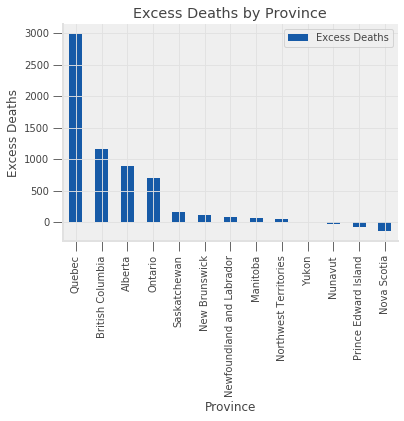

In [27]:
excess_by_province.plot.bar()
plt.xlabel('Province')
plt.ylabel('Excess Deaths')
plt.title('Excess Deaths by Province')
plt.show()

In [28]:
#Cleaning income data
income_df = income_data[['REF_DATE','GEO','VALUE']]
income_df = income_df.rename(columns={'REF_DATE':'Year','VALUE':'Median Income'})

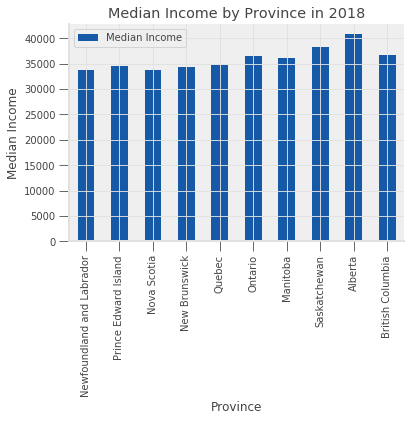

In [29]:
income_df.plot.bar(x='GEO',y='Median Income')
plt.title('Median Income by Province in 2018')
plt.xlabel('Province')
plt.ylabel('Median Income')
plt.show() 

# Comparing the Impact of COVID Across Provinces

In [30]:
#Calculating case and death averages over 7 and 14 days and active cases per 100k people
coviddf['7D case average'] = coviddf.groupby('province').rolling(7)['cases'].mean().reset_index(drop=True).fillna(0)
coviddf['14D case average'] = coviddf.groupby('province').rolling(14)['cases'].mean().reset_index(drop=True).fillna(0)

coviddf['7D death average'] = coviddf.groupby('province').rolling(7)['deaths'].mean().reset_index(drop=True).fillna(0)
coviddf['14D death average'] = coviddf.groupby('province').rolling(14)['deaths'].mean().reset_index(drop=True).fillna(0)

coviddf['7D cases per 100k'] = coviddf['7D case average'].div(coviddf['Pop/100k'])
coviddf['14D cases per 100k'] = coviddf['14D case average'].div(coviddf['Pop/100k'])

coviddf['Total deaths per 100k'] = coviddf['cumulative_deaths'].div(coviddf['Pop/100k'])
coviddf['Total cases per 100k'] = coviddf['cumulative cases'].div(coviddf['Pop/100k'])
coviddf['Active cases per 100k'] = coviddf['active_cases'].div(coviddf['Pop/100k'])

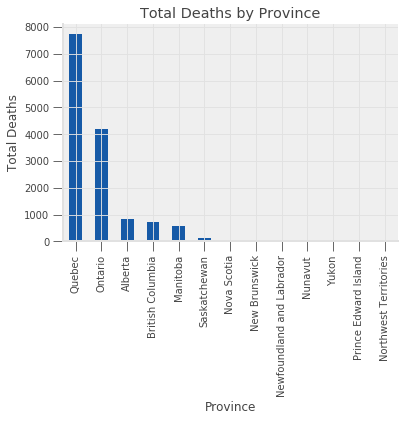

In [31]:
death_by_province = coviddf.groupby('province')['cumulative_deaths'].last(1).sort_values(ascending=False)
death_by_province.plot.bar()
plt.ylabel("Total Deaths")
plt.xlabel('Province')
plt.title("Total Deaths by Province")
plt.show()

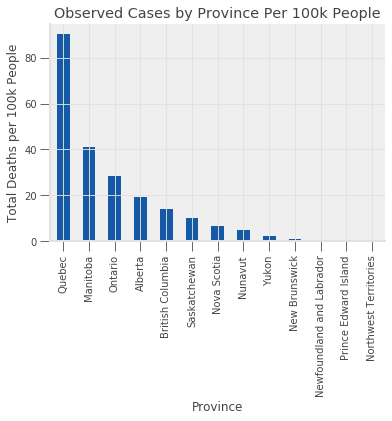

In [32]:
death_by_province_per100k = coviddf.groupby('province')['Total deaths per 100k'].last(1).sort_values(ascending=False)
death_by_province_per100k.plot.bar()
plt.ylabel("Total Deaths per 100k People")
plt.xlabel('Province')
plt.title("Observed Cases by Province Per 100k People")
plt.show()

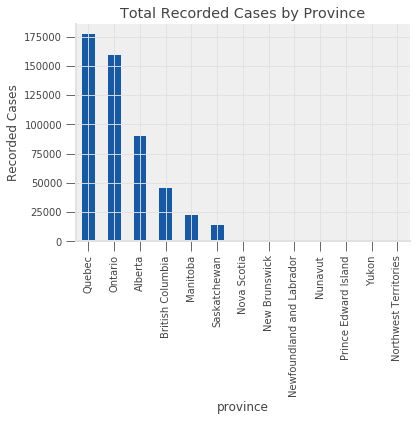

In [33]:
cases_by_province = coviddf.groupby('province')['cumulative cases'].last(1).sort_values(ascending=False)
cases_by_province.plot.bar()
plt.ylabel("Recorded Cases")
plt.title("Total Recorded Cases by Province")
plt.show()

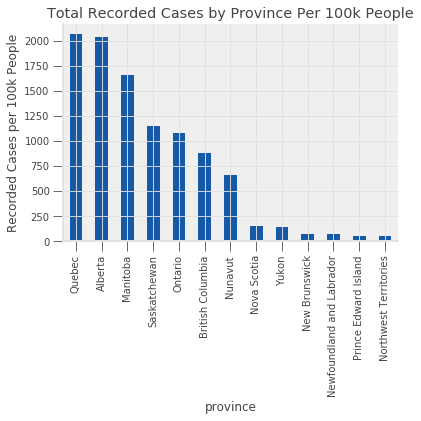

In [34]:
cases_by_province_per100k = coviddf.groupby('province')['Total cases per 100k'].last(1).sort_values(ascending=False)
cases_by_province_per100k.plot.bar()
plt.ylabel("Recorded Cases per 100k People")
plt.title("Total Recorded Cases by Province Per 100k People")
plt.show()

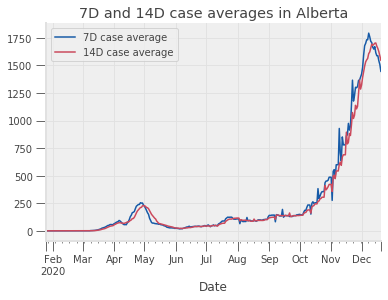

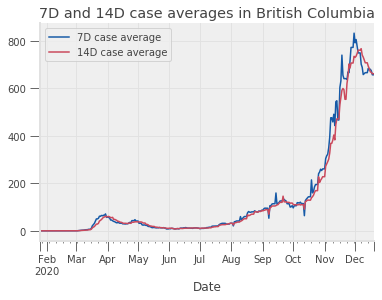

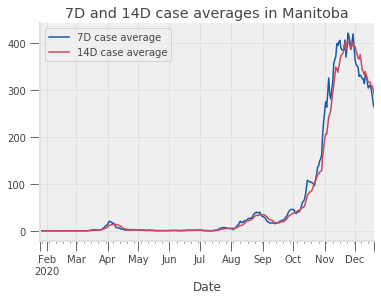

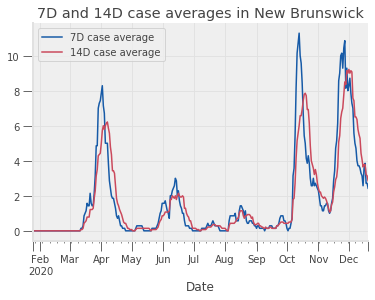

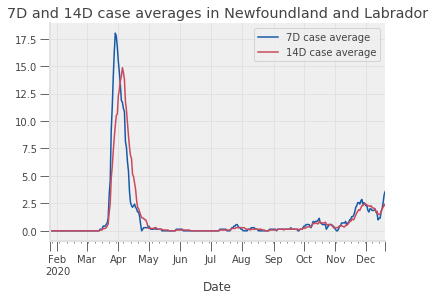

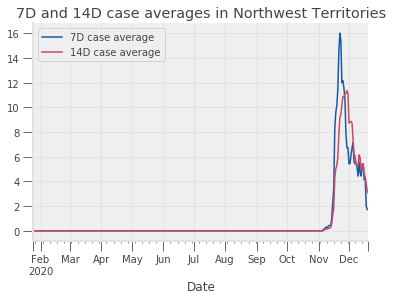

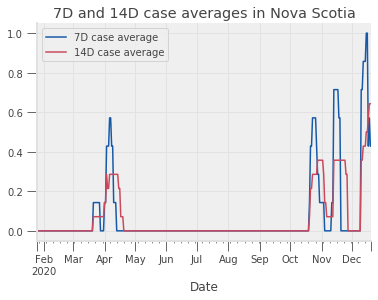

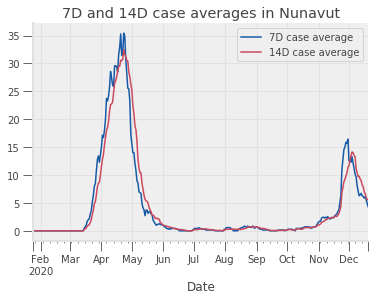

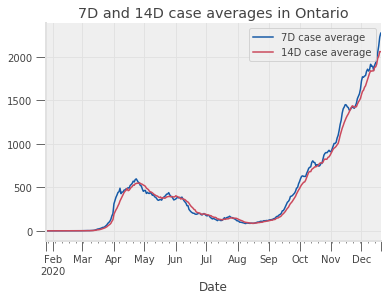

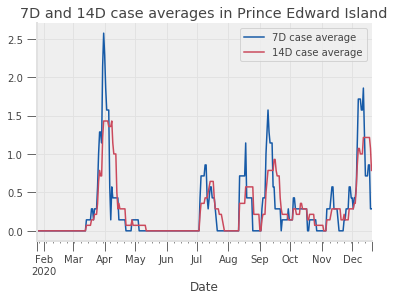

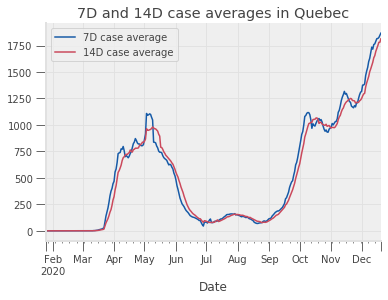

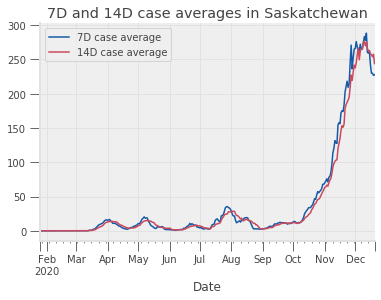

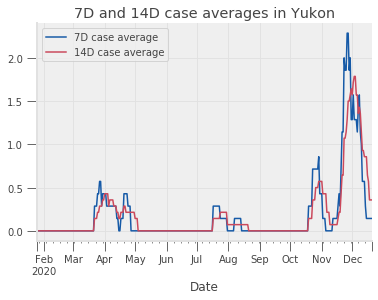

In [35]:
for title, group in coviddf.groupby('province'):
    group.plot(x='Date', y=['7D case average','14D case average'], title=(f'7D and 14D case averages in {title}'))
plt.show() 

In [36]:
active_cases = coviddf.groupby('province')['Active cases per 100k'].last(1)
active_cases = active_cases.to_frame()
map_df = map_data[['PRENAME','geometry']]
geoplot = map_df.merge(active_cases, left_on='PRENAME', right_on='province')

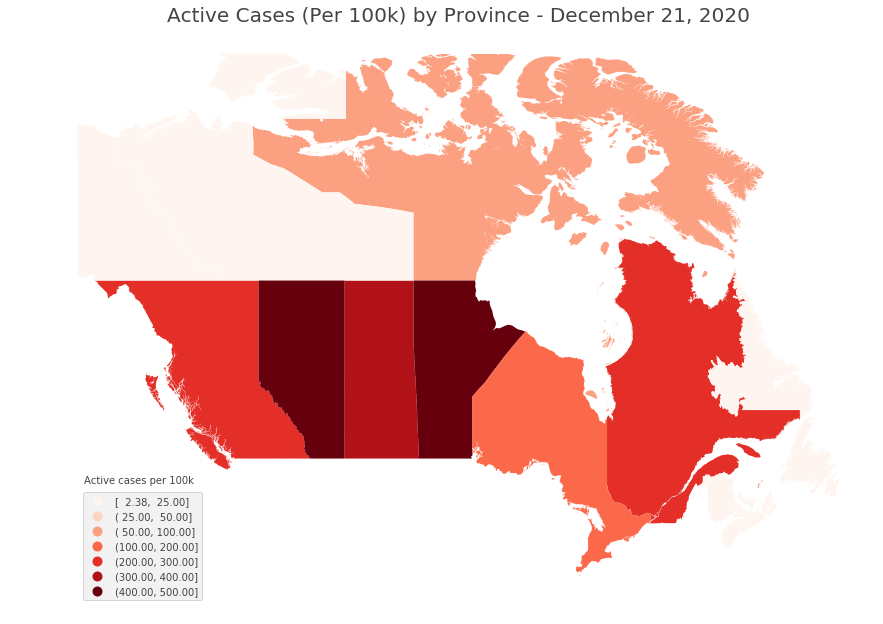

In [37]:
date = dt.date.today().strftime("%B %d, %Y")

fig, gax = plt.subplots(figsize=(15,15))

geoplot.plot(ax=gax,column='Active cases per 100k', cmap ='Reds', figsize=(15,9), scheme='user_defined', legend = True,
         classification_kwds={'bins':[25,50,100,200,300,400,500]});

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
gax.set_title(f"Active Cases (Per 100k) by Province - {date}",fontsize=20)

leg = gax.get_legend()
leg.set_bbox_to_anchor((0., 0., 0.2, 0.2))
gax.annotate('Active cases per 100k',xy=(0.095, 0.225),  xycoords='figure fraction')

plt.axis('off')
plt.show()

In [38]:
#Estimating unemployment by taking the average unemployment rate by province by month for the last 10 years
unempdf = unempdf[(unempdf.Date < '2020-01') | (unempdf.Date > '2009-12')]
unempdf.head(1) 

,Date,GEO,Labour force,Month,Unemprate
0,1999-01,Newfoundland and Labrador,225100.0,1,0.184


In [39]:
unempdf = unempdf[['GEO','Unemprate','Month']]
unemp_estimates = unempdf.groupby(['GEO','Month']).mean()
unemp_estimates = unemp_estimates.rename(columns={'Unemprate':'Estimated Unemp'})
unemp_estimates.head()

Estimated Unemp
GEO     Month                 
Alberta 1             0.057364
        2             0.056364
        3             0.057136
        4             0.060000
        5             0.059955

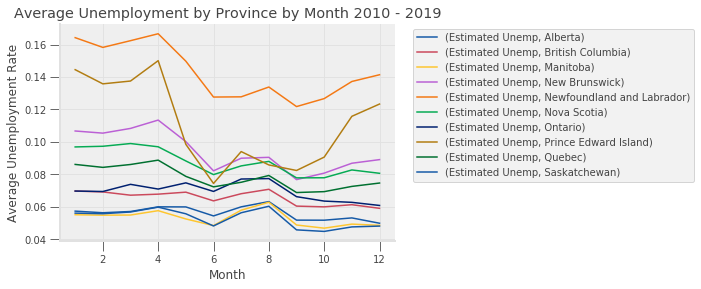

In [40]:
unemp_estimates.unstack(level=0).plot(kind='line')
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.title('Average Unemployment by Province by Month 2010 - 2019')
plt.xlabel('Month')
plt.ylabel('Average Unemployment Rate')
plt.show() 

In [41]:
unemp2020 = unemp2020.sort_values('GEO')
unemp2020 = pd.merge(unemp2020, unemp_estimates,on=['GEO','Month'])
unemp2020['Unemp Diff'] = unemp2020['Unemprate'] - unemp2020['Estimated Unemp']
unemp2020['Job Diff'] = unemp2020['Labour force'] * unemp2020['Unemp Diff']
unemp2020.head(1) 

,Date,GEO,Labour force,Month,Unemprate,Estimated Unemp,Unemp Diff,Job Diff
0,2020-08,Alberta,2501500.0,8,0.128,0.063227,0.064773,162028.977273


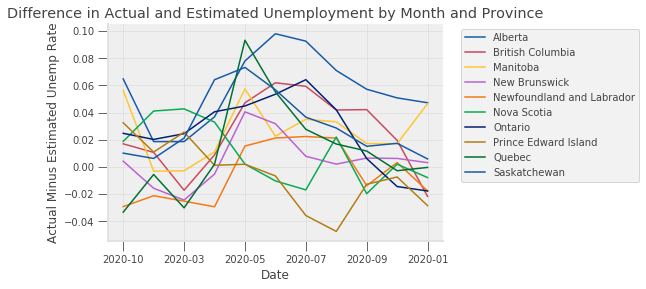

In [42]:
fig, ax = plt.subplots()

for prov, grp in unemp2020.groupby(['GEO']):
    ax = grp.plot(ax=ax, kind='line', x='Date', y='Unemp Diff', label=prov)

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('Actual Minus Estimated Unemp Rate')
plt.title('Difference in Actual and Estimated Unemployment by Month and Province')
plt.show()

In [43]:
coviddf = coviddf[coviddf["Date"].dt.is_month_end]
pd.set_option('display.max_columns', None)
coviddf = coviddf.drop(columns={'cases','active_cases_change','7D case average','7D death average'})
coviddf = coviddf.merge(unemp2020,left_on=['province','Year-Month'],right_on=['GEO','Date'])
coviddf.head(1) 

,province,Date_x,cumulative cases,cumulative_deaths,active_cases,deaths,Year-Month,Month_x,Quarter,Population,Pop/100k,14D case average,14D death average,7D cases per 100k,14D cases per 100k,Total deaths per 100k,Total cases per 100k,Active cases per 100k,Date_y,GEO,Labour force,Month_y,Unemprate,Estimated Unemp,Unemp Diff,Job Diff
0,Alberta,2020-01-31,0,0,0,0.0,2020-01,01,1,4402045,44.02045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2020-01,Alberta,2468500.0,1,0.076,0.057364,0.018636,46003.863636


In [44]:
coviddf = coviddf[['province','Date_x','cumulative cases','cumulative_deaths','active_cases','Pop/100k','Unemp Diff','Job Diff']]
coviddf = coviddf.rename(columns={'Date_x':'Date','Month_x':'Month'})
coviddf = coviddf.merge(income_df,left_on='province',right_on='GEO')
coviddf = coviddf.drop(['GEO','Year'],axis=1)
coviddf.head(1) 

,province,Date,cumulative cases,cumulative_deaths,active_cases,Pop/100k,Unemp Diff,Job Diff,Median Income
0,Alberta,2020-01-31,0,0,0,44.02045,0.018636,46003.863636,40800


In [45]:
coviddf['Lost income'] = coviddf['Job Diff'] * coviddf['Median Income'] * 1/12
coviddf['Lost income'] = coviddf['Lost income'].astype(int)
coviddf['Lost income'][coviddf['Lost income'] < 0] = 0
coviddf['Cumulative lost income'] = coviddf.groupby('province')['Lost income'].cumsum()

In [46]:
VOSL = 5000000
lost_income = coviddf.groupby('province')['Cumulative lost income'].last(1).astype('int64')
lost_income = lost_income.to_frame() 
lost_income['VOSL Lost'] = lost_income['Cumulative lost income'] / VOSL

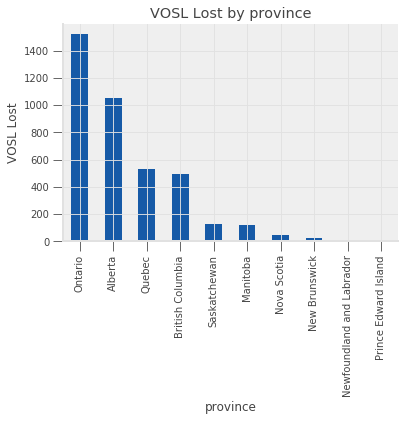

In [47]:
VOSL_lost = lost_income['VOSL Lost'].sort_values(ascending=False)
VOSL_lost.plot.bar()
plt.ylabel("VOSL Lost")
plt.title("VOSL Lost by province")
plt.show()

In [48]:
covid_by_month = coviddf.groupby('Date')
sept_df = covid_by_month.get_group('2020-09-30')
sept_df = sept_df.merge(VOSL_lost, left_on='province',right_on='province')
sept_df = sept_df.merge(excess_by_province, left_on='province',right_on='GEO')

sept_df['Excess Less Covid'] = sept_df['Excess Deaths'] - sept_df['cumulative_deaths']

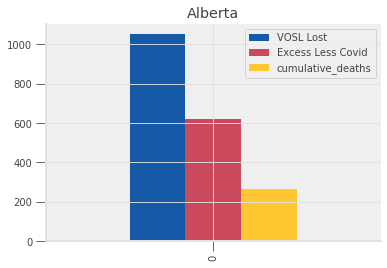

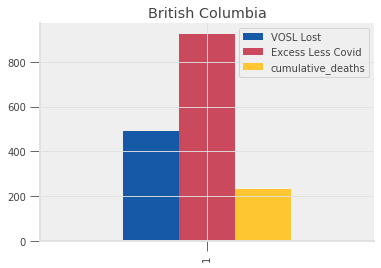

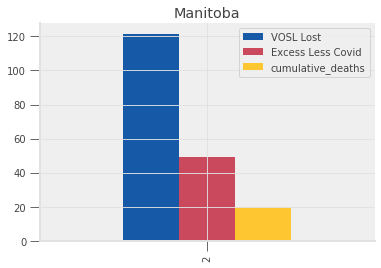

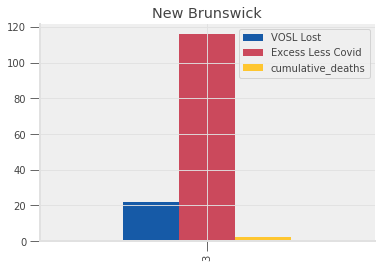

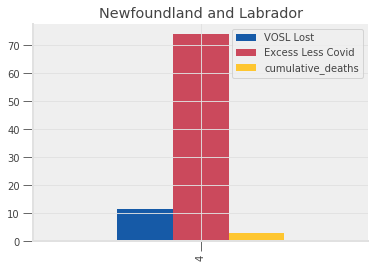

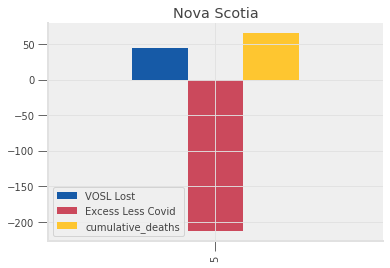

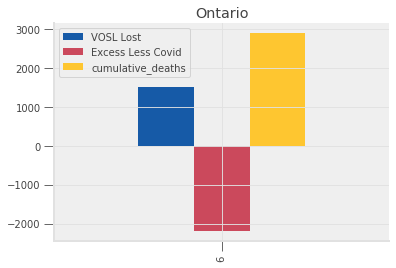

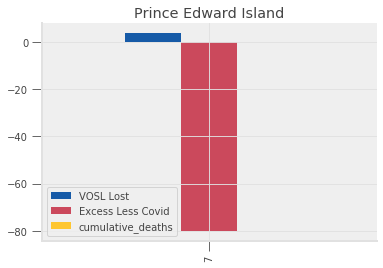

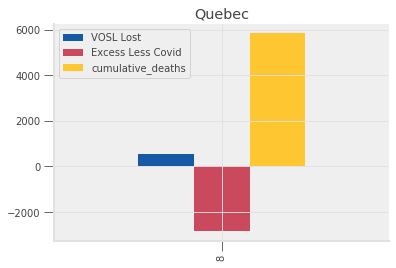

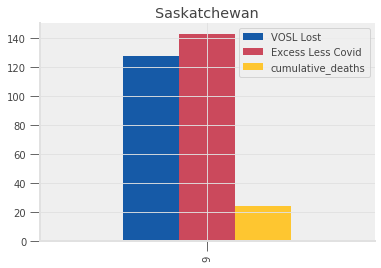

In [49]:
for title, group in sept_df.groupby('province'):
    group.plot(y=['VOSL Lost','Excess Less Covid','cumulative_deaths'], kind='bar',title=title)

In [50]:
sept_df['Excess Deaths'][sept_df['Excess Deaths'] < 0] = 0
sept_df['Excess Less Covid'] = sept_df['Excess Deaths'] - sept_df['cumulative_deaths']
sept_df['Excess Less Covid'][sept_df['Excess Less Covid'] < 0] = 0

sept_df['Net Covid Deaths'] = sept_df['cumulative_deaths'] - sept_df['VOSL Lost'] - sept_df['Excess Less Covid']
sept_df['Total Deaths'] = sept_df['cumulative_deaths'] + sept_df['VOSL Lost'] + sept_df['Excess Less Covid']
sept_df['Covid to Non-Covid Death Ratio'] = sept_df['Net Covid Deaths'].div(sept_df['Total Deaths'])

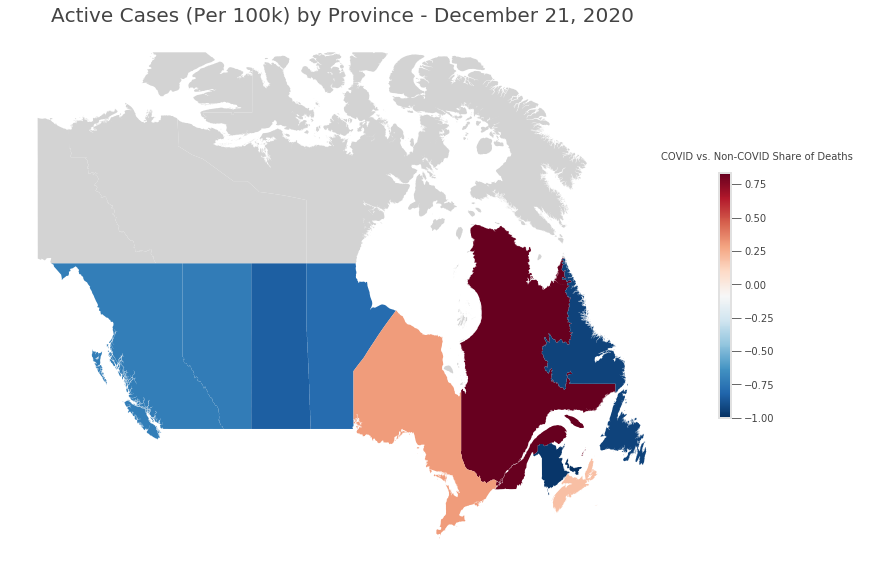

In [51]:
geoplot2 = map_df.merge(sept_df, left_on='PRENAME', right_on='province',how='outer')

fig, gax = plt.subplots(figsize=(15,15))

geoplot2.plot(ax=gax,column='Covid to Non-Covid Death Ratio', cmap ='RdBu_r', 
              missing_kwds={'color': 'lightgrey',"label": "Missing values"},
              legend = True,legend_kwds={'shrink': 0.3});

gax.annotate('COVID vs. Non-COVID Share of Deaths',xy=(0.75, 0.72),  xycoords='figure fraction')

gax.spines['top'].set_visible(False)
gax.spines['right'].set_visible(False)
gax.set_title(f"Active Cases (Per 100k) by Province - {date}",fontsize=20)
plt.axis('off')

plt.show()

In [52]:
coviddf['Monthly Deaths Per 100k'] = coviddf.groupby('province')['cumulative_deaths'].diff().div(coviddf['Pop/100k']).fillna(0)
coviddf['Monthly Cases Per 100k'] = coviddf.groupby('province')['cumulative cases'].diff().div(coviddf['Pop/100k']).fillna(0)
coviddf.head(1)

,province,Date,cumulative cases,cumulative_deaths,active_cases,Pop/100k,Unemp Diff,Job Diff,Median Income,Lost income,Cumulative lost income,Monthly Deaths Per 100k,Monthly Cases Per 100k
0,Alberta,2020-01-31,0,0,0,44.02045,0.018636,46003.863636,40800,156413136,156413136,0.0,0.0


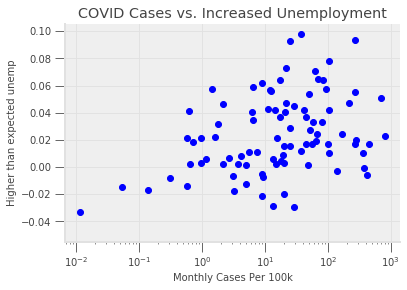

In [53]:
fig = plt.figure()
ax = plt.gca()
ax.plot(coviddf['Monthly Cases Per 100k'] , coviddf['Unemp Diff'], 'o',c='b')
ax.set_xscale('log')
plt.xlabel('Monthly Cases Per 100k', fontsize=10)
plt.ylabel('Higher than expected unemp', fontsize=10)
plt.title('COVID Cases vs. Increased Unemployment')
plt.show()

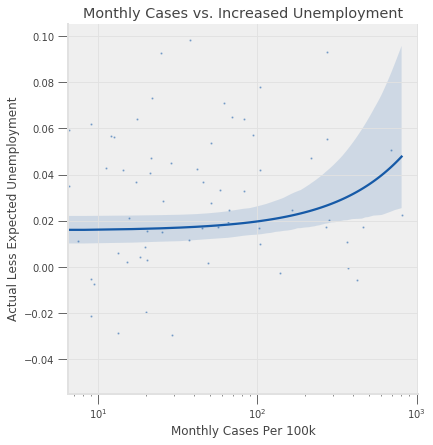

In [54]:
grid = sns.lmplot(data=coviddf, x="Monthly Cases Per 100k", y="Unemp Diff", height=6,
    scatter_kws=dict(s=1.5, alpha=0.35),);
grid.set(xscale="log")

plt.title('Monthly Cases vs. Increased Unemployment')
plt.ylabel('Actual Less Expected Unemployment')

plt.show()

In [55]:
growth_model = linear_model.LinearRegression()
growth_model.fit(coviddf[["Monthly Cases Per 100k"]],coviddf["Unemp Diff"])
beta_0 = growth_model.intercept_
beta_1 = growth_model.coef_[0]
print(f"Fit model: Higher than average unemp = {beta_0:.4f} + {beta_1:.4f} * Monthly Covid Cases Per 100k")

Fit model: Higher than average unemp = 0.0157 + 0.0000 * Monthly Covid Cases Per 100k


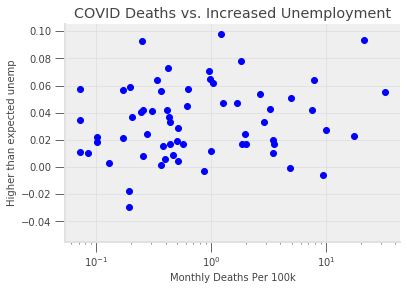

In [56]:
fig = plt.figure()
ax = plt.gca()
ax.plot(coviddf['Monthly Deaths Per 100k'] , coviddf['Unemp Diff'], 'o',c='b')
ax.set_xscale('log')
plt.xlabel('Monthly Deaths Per 100k', fontsize=10)
plt.ylabel('Higher than expected unemp', fontsize=10)
plt.title('COVID Deaths vs. Increased Unemployment')
plt.show()

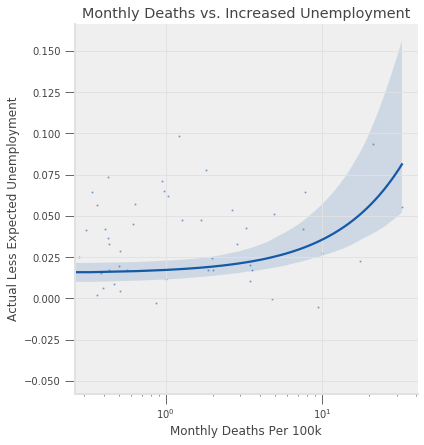

In [57]:
grid = sns.lmplot(data=coviddf, x="Monthly Deaths Per 100k", y="Unemp Diff", height=6,
    scatter_kws=dict(s=1.5, alpha=0.35),);

grid.set(xscale="log")
plt.title('Monthly Deaths vs. Increased Unemployment')
plt.ylabel('Actual Less Expected Unemployment')

plt.show()

In [58]:
growth_model = linear_model.LinearRegression()
growth_model.fit(coviddf[["Monthly Deaths Per 100k"]],coviddf["Unemp Diff"])
beta_0 = growth_model.intercept_
beta_1 = growth_model.coef_[0]
print(f"Fit model: Higher than average unemp = {beta_0:.4f} + {beta_1:.4f} * Monthly Covid Deaths Per 100k")

Fit model: Higher than average unemp = 0.0151 + 0.0020 * Monthly Covid Deaths Per 100k


In [59]:
#multivariable regression if we can get to it.

In [60]:
elapsed = timeit.default_timer() - start_time
elapsed

16.40524